In [21]:
# =========================
# 1) Setup & Imports
# =========================
!pip -q install openpyxl

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU available: []


In [22]:
# =========================
# 2) Mount Google Drive
# =========================
from google.colab import drive
drive.mount('/content/drive')

# Path to your folder in Drive
FOLDER_PATH = "/content/drive/MyDrive/Colab Notebooks/Pyton basic"

# Expected file name (change if needed)
FILE_NAME = "dataset.xlsx"

EXCEL_PATH = os.path.join(FOLDER_PATH, FILE_NAME)

# Smart check: if file not found, show folder contents
if not os.path.exists(EXCEL_PATH):
    print(f"❌ File not found: {EXCEL_PATH}")
    print("🔎 Listing files in folder instead:")
    print("="*60)
    for f in os.listdir(FOLDER_PATH):
        print(f)
else:
    print(f"✅ File found: {EXCEL_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ File found: /content/drive/MyDrive/Colab Notebooks/Pyton basic/Example data.xlsx


In [23]:
# =========================
# 3) Load & Inspect Data
# =========================
df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME, engine='openpyxl')

# Normalize column names for easy matching
df.columns = [c.strip() for c in df.columns]
cols_lower = {c.lower(): c for c in df.columns}

# Identify date & target columns (case-insensitive)
DATE_COL = None
for candidate in ['date', 'timestamp', 'datetime']:
    if candidate in cols_lower:
        DATE_COL = cols_lower[candidate]; break

TARGET_COL = None
for candidate in ['close', 'adj close', 'adj_close', 'closing price', 'price']:
    if candidate in cols_lower:
        TARGET_COL = cols_lower[candidate]; break

if DATE_COL is None:
    raise ValueError("Could not find a date column (e.g., 'Date'). Please rename or set DATE_COL manually.")
if TARGET_COL is None:
    raise ValueError("Could not find a target price column (e.g., 'Close' or 'Adj Close'). Please rename or set TARGET_COL manually.")

# Basic cleanup
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
df = df.dropna(subset=[DATE_COL, TARGET_COL]).sort_values(DATE_COL).reset_index(drop=True)

print("Using columns:")
print("Date column  :", DATE_COL)
print("Target column:", TARGET_COL)
df.head()


Using columns:
Date column  : Date
Target column: Close


,Date,Close
0,2020-11-02 15:29:59.712,32.80
1,2020-11-03 15:29:59.712,32.95
2,2020-11-04 15:29:59.712,32.70
3,2020-11-05 15:29:59.712,33.00
4,2020-11-06 15:29:59.712,32.85


In [24]:
# =========================
# 4) Optional: add extra features
#    (You can expand this block with your own indicators)
# =========================
# Simple technicals: returns and moving averages
df['ret_1'] = df[TARGET_COL].pct_change()
df['ma_5']  = df[TARGET_COL].rolling(5).mean()
df['ma_10'] = df[TARGET_COL].rolling(10).mean()
df['vol_5'] = df[TARGET_COL].rolling(5).std()

# Drop initial NaNs from indicators
df = df.dropna().reset_index(drop=True)

# Feature set: you can add more columns here
FEATURE_COLS = [TARGET_COL, 'ret_1', 'ma_5', 'ma_10', 'vol_5']

data = df[FEATURE_COLS].values.astype(np.float32)
dates = df[DATE_COL].values


In [25]:
# =========================
# 5) Scale & Create Sequences
# =========================
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

SEQ_LEN = 60   # past days to look at
HORIZON = 1    # predict next day
def make_sequences(arr, seq_len=60, horizon=1, target_index=0):
    X, y = [], []
    for i in range(seq_len, len(arr) - horizon + 1):
        X.append(arr[i-seq_len:i, :])
        y.append(arr[i + horizon - 1, target_index])  # target is 'Close' scaled
    return np.array(X), np.array(y)

X, y = make_sequences(data_scaled, SEQ_LEN, HORIZON, target_index=0)
seq_dates = dates[SEQ_LEN - 1: len(dates) - HORIZON + 1]  # align dates with X/y

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (1041, 60, 5) y shape: (1041,)


In [26]:
# =========================
# 6) Train/Validation/Test Split (time-series safe)
# =========================
total = len(X)
train_end = int(0.7 * total)
val_end   = int(0.85 * total)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]
dates_test       = seq_dates[val_end:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (728, 60, 5), Val: (156, 60, 5), Test: (157, 60, 5)


In [27]:
# =========================
# 7) Build LSTM Model
# =========================
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # next-day close (scaled)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse')

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# =========================
# 8) Train
# =========================
ckpt_path = '/content/best_lstm.h5'
callbacks = [
    ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.0469
Epoch 1: val_loss improved from inf to 0.00306, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step - loss: 0.0454 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0076
Epoch 2: val_loss did not improve from 0.00306
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - loss: 0.0075 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0044
Epoch 3: val_loss did not improve from 0.00306
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.0044 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0035
Epoch 4: val_loss improved from 0.00306 to 0.00306, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 0.0035 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0032
Epoch 5: val_loss did not improve from 0.00306
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - loss: 0.0032 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0030
Epoch 6: val_loss improved from 0.00306 to 0.00272, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 0.0030 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0034
Epoch 7: val_loss did not improve from 0.00272
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: 0.0034 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0030
Epoch 8: val_loss improved from 0.00272 to 0.00252, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - loss: 0.0030 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0028
Epoch 9: val_loss improved from 0.00252 to 0.00207, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 0.0028 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0030
Epoch 10: val_loss did not improve from 0.00207
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 0.0030 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0025
Epoch 11: val_loss did not improve from 0.00207
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - loss: 0.0025 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0028
Epoch 12: val_loss improved from 0.00207 to 0.00194, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 0.0028 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0024
Epoch 13: val_loss did not improve from 0.00194
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0024 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0023
Epoch 14: val_loss did not improve from 0.00194
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0023 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0029
Epoch 15: val_loss did not improve from 0.00194
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0028 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 16/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.0027
Epoch 16: val_loss improved from 0.00194 to 0.00159, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - loss: 0.0027 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 17/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0025
Epoch 17: val_loss did not improve from 0.00159
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0025 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 18/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0019
Epoch 18: val_loss improved from 0.00159 to 0.00151, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - loss: 0.0019 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 19/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0023
Epoch 19: val_loss did not improve from 0.00151
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - loss: 0.0023 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 20/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0018
Epoch 20: val_loss did not improve from 0.00151
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0018 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 21/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.0024
Epoch 21: val_loss did not improve from 0.00151

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - loss: 0.0024 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 22/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0017
Epoch 22: val_loss improved from 0.00151 to 0.00139, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0017 - val_loss: 0.0014 - learning_rate: 5.0000e-04
Epoch 23/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0016
Epoch 23: val_loss improved from 0.00139 to 0.00136, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 0.0016 - val_loss: 0.0014 - learning_rate: 5.0000e-04
Epoch 24/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0019
Epoch 24: val_loss did not improve from 0.00136
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.0019 - val_loss: 0.0022 - learning_rate: 5.0000e-04
Epoch 25/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.0019
Epoch 25: val_loss did not improve from 0.00136
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 0.0019 - val_loss: 0.0027 - learning_rate: 5.0000e-04
Epoch 26/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0021
Epoch 26: val_loss did not improve from 0.00136
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - loss: 0.0021 - val_loss: 0.0016 - learning_rate: 5.0000e-04
Epoch 27/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0017
Epoch 27: val_loss did not improve from 0.00136

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step -

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 2.5000e-04
Epoch 32/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0016
Epoch 32: val_loss did not improve from 0.00130

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 2.5000e-04
Epoch 33/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0018
Epoch 33: val_loss improved from 0.00130 to 0.00119, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 0.0017 - val_loss: 0.0012 - learning_rate: 1.2500e-04
Epoch 34/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.0015
Epoch 34: val_loss did not improve from 0.00119
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 1.2500e-04
Epoch 35/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0017
Epoch 35: val_loss improved from 0.00119 to 0.00114, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0016 - val_loss: 0.0011 - learning_rate: 1.2500e-04
Epoch 36/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.0016
Epoch 36: val_loss did not improve from 0.00114
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - loss: 0.0016 - val_loss: 0.0013 - learning_rate: 1.2500e-04
Epoch 37/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0016
Epoch 37: val_loss improved from 0.00114 to 0.00112, saving model to /content/best_lstm.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - loss: 0.0016 - val_loss: 0.0011 - learning_rate: 1.2500e-04
Epoch 38/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0018
Epoch 38: val_loss did not improve from 0.00112

Epoch 38: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 0.0018 - val_loss: 0.0011 - learning_rate: 1.2500e-04
Epoch 39/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0016
Epoch 39: val_loss did not improve from 0.00112
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0016 - val_loss: 0.0012 - learning_rate: 6.2500e-05
Epoch 40/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - loss: 0.0018
Epoch 40: val_loss did not improve from 0.00112
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 0.0018 - val_loss: 0.0013 - learning_rate: 6.2500e-05
Epoch 41/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0019
Epoch 41: val_loss did not improve from 0.00112
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - 

In [29]:
# =========================
# 9) Evaluate (on Test)
# =========================
pred_test_scaled = model.predict(X_test).flatten()
true_test_scaled = y_test.flatten()

def invert_target(scaled_series, scaler, feature_index=0):
    filler = np.zeros((len(scaled_series), scaler.n_features_in_), dtype=np.float32)
    filler[:, feature_index] = scaled_series
    inv = scaler.inverse_transform(filler)
    return inv[:, feature_index]

pred_test = invert_target(pred_test_scaled, scaler, 0)
true_test = invert_target(true_test_scaled, scaler, 0)

mae  = mean_absolute_error(true_test, pred_test)
mse  = mean_squared_error(true_test, pred_test)
rmse = np.sqrt(mse)
r2   = r2_score(true_test, pred_test)

print(f"Test MAE : {mae:,.4f}")
print(f"Test RMSE: {rmse:,.4f}")
print(f"Test R²  : {r2:,.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
Test MAE : 1.7460
Test RMSE: 2.3942
Test R²  : 0.8817


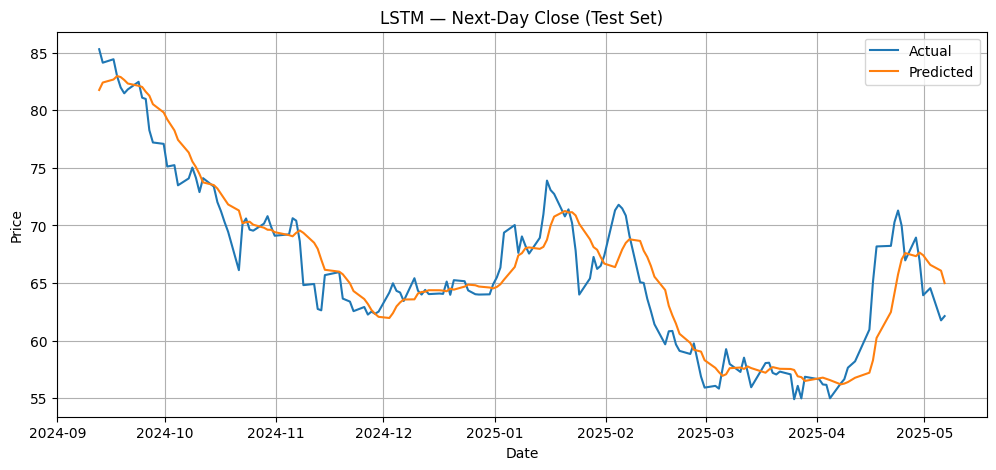

In [31]:
# =========================
# 10) Plot Predictions vs Actual (fixed)
# =========================
plt.figure(figsize=(12,5))
plt.plot(dates_test[:len(true_test)], true_test, label='Actual')
plt.plot(dates_test[:len(pred_test)], pred_test, label='Predicted')
plt.title('LSTM — Next-Day Close (Test Set)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# =========================
# 11) Save Model & Scaler (optional)
# =========================
model.save('/content/lstm_stock_model.keras')
import joblib
joblib.dump(scaler, '/content/feature_scaler.pkl')

print("Saved:", '/content/lstm_stock_model.keras', 'and', '/content/feature_scaler.pkl')


Saved: /content/lstm_stock_model.keras and /content/feature_scaler.pkl


In [33]:
# =========================
# 12) Make a One-Step-Ahead Forecast for the most recent window
# =========================
last_window = data_scaled[-SEQ_LEN:]  # last seq_len rows
last_window = np.expand_dims(last_window, axis=0)
next_scaled = model.predict(last_window).flatten()[0]
next_pred   = invert_target(np.array([next_scaled]), scaler, feature_index=0)[0]

print("Most recent available date:", df[DATE_COL].iloc[-1].date())
print("Next-day predicted Close  :", round(float(next_pred), 4))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Most recent available date: 2025-05-07
Next-day predicted Close  : 64.1828


In [34]:
TARGET_COL = 'Adj Close'


In [39]:
# =========================
# Generate Buy/Sell/Hold Signals
# =========================

signals = []

for i in range(len(future_df)):
    if i == 0:
        signals.append("HOLD")  # first prediction = no previous day
    else:
        if future_df["Predicted_Close"].iloc[i] > future_df["Predicted_Close"].iloc[i-1]:
            signals.append("BUY")
        elif future_df["Predicted_Close"].iloc[i] < future_df["Predicted_Close"].iloc[i-1]:
            signals.append("SELL")
        else:
            signals.append("HOLD")

# Add to DataFrame
future_df["Signal"] = signals

# Show table
import pandas as pd
from IPython.display import display

display(future_df)

# Save to CSV for Power BI
future_df.to_csv("/content/Stock_Forecast_Signals.csv", index=False)
print("✅ File saved with Buy/Sell/Hold signals: Stock_Forecast_Signals.csv")


,Date,Predicted_Close,Signal
0,2025-05-08 15:29:59.712,64.182800,HOLD
1,2025-05-09 15:29:59.712,63.668125,SELL
2,2025-05-12 15:29:59.712,63.348831,SELL
3,2025-05-13 15:29:59.712,63.158798,SELL
4,2025-05-14 15:29:59.712,63.053219,SELL
5,2025-05-15 15:29:59.712,63.001736,SELL
6,2025-05-16 15:29:59.712,62.984108,SELL
7,2025-05-19 15:29:59.712,62.987213,BUY
8,2025-05-20 15:29:59.712,63.002586,BUY
9,2025-05-21 15:29:59.712,63.024849,BUY


✅ File saved with Buy/Sell/Hold signals: Stock_Forecast_Signals.csv


from matplotlib import pyplot as plt
future_df['Predicted_Close'].plot(kind='hist', bins=20, title='Predicted_Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
future_df.groupby('Signal').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Predicted_Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = future_df.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Signal')):
  _plot_series(series, series_name, i)
  fig.legend(title='Signal', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Predicted_Close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = future_df.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Signal')):
  _plot_series(series, series_name, i)
  fig.legend(title='Signal', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Predicted_Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = future_df.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Signal')):
  _plot_series(series, series_name, i)
  fig.legend(title='Signal', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Predicted_Close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = future_df.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Signal')):
  _plot_series(series, series_name, i)
  fig.legend(title='Signal', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
future_df['Predicted_Close'].plot(kind='line', figsize=(8, 4), title='Predicted_Close')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(future_df['Signal'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(future_df, x='Predicted_Close', y='Signal', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available columns: Index(['Date', 'Close'], dtype='object')
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.0453 - val_loss: 0.0035
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0022 - 

,Date,Predicted_Close
0,2025-05-08 15:29:59.712,65.950188
1,2025-05-09 15:29:59.712,65.401169
2,2025-05-10 15:29:59.712,65.213409
3,2025-05-11 15:29:59.712,65.222992
4,2025-05-12 15:29:59.712,65.343315
5,2025-05-13 15:29:59.712,65.528023
6,2025-05-14 15:29:59.712,65.751755
7,2025-05-15 15:29:59.712,66.000084
8,2025-05-16 15:29:59.712,66.264465
9,2025-05-17 15:29:59.712,66.539497


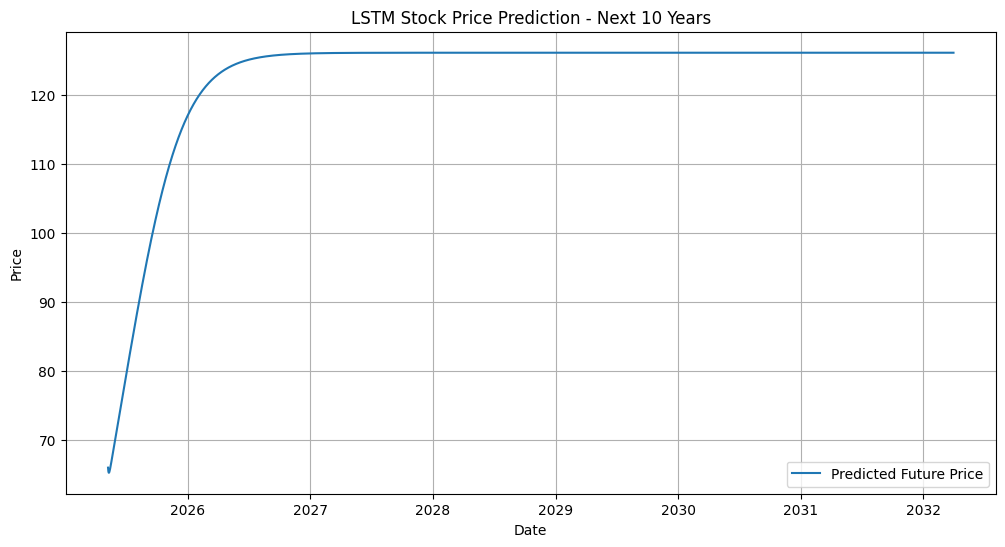

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [44]:
# ===============================
# LSTM Stock Prediction (10 Years)
# ===============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import drive
import datetime

# ===============================
# 1) Mount Google Drive & Load Data
# ===============================
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Colab Notebooks/Pyton basic/Example data.xlsx"
df = pd.read_excel(file_path)

print("Available columns:", df.columns)

# Pick the right column (change 'Close' to match your file)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
prices = df['Close'].values.reshape(-1,1)   # CHANGE if column name differs

# ===============================
# 2) Data Preprocessing
# ===============================
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(prices)

seq_len = 60
X, y = [], []
for i in range(seq_len, len(scaled_prices)):
    X.append(scaled_prices[i-seq_len:i])
    y.append(scaled_prices[i])
X, y = np.array(X), np.array(y)

split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ===============================
# 3) Build LSTM Model
# ===============================
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# ===============================
# 4) Forecast Future (10 years ≈ 2520 trading days)
# ===============================
future_days = 2520
last_seq = scaled_prices[-seq_len:]
future_predictions = []
current_seq = last_seq

for _ in range(future_days):
    pred = model.predict(current_seq.reshape(1, seq_len, 1), verbose=0)
    future_predictions.append(pred[0,0])
    current_seq = np.append(current_seq[1:], pred).reshape(seq_len,1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

# ===============================
# 5) Prepare Output DataFrame
# ===============================
last_date = df['Date'].iloc[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1,future_days+1)]

future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Close": future_predictions.flatten()
})

# ===============================
# 6) Print BUY / SELL / HOLD
# ===============================
today_price = prices[-1][0]
next_day_price = future_predictions[0][0]

if next_day_price > today_price * 1.02:
    print("📈 Best time to BUY stocks (price expected to rise).")
elif next_day_price < today_price * 0.98:
    print("📉 Best time to SELL stocks (price expected to drop).")
else:
    print("⏸ Best to HOLD stocks (no major change).")

# ===============================
# 7) Show Future Predictions Table
# ===============================
import IPython.display as disp
disp.display(future_df.head(10))  # show first 10 rows

# ===============================
# 8) Plot Predictions
# ===============================
plt.figure(figsize=(12,6))
plt.plot(future_df["Date"], future_df["Predicted_Close"], label="Predicted Future Price")
plt.title("LSTM Stock Price Prediction - Next 10 Years")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
# ===============================
# LSTM Stock Prediction (10 Years)
# ===============================

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from google.colab import drive
import datetime

# ===============================
# 1) Mount Google Drive & Load Data
# ===============================
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Colab Notebooks/Pyton basic/Example data.xlsx"
df = pd.read_excel(file_path)

print("Available columns:", df.columns)

# Pick the right column (change 'Close' to match your file)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
prices = df['Close'].values.reshape(-1,1)   # CHANGE if column name differs

# ===============================
# 2) Data Preprocessing
# ===============================
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(prices)

seq_len = 60
X, y = [], []
for i in range(seq_len, len(scaled_prices)):
    X.append(scaled_prices[i-seq_len:i])
    y.append(scaled_prices[i])
X, y = np.array(X), np.array(y)

split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ===============================
# 3) Build LSTM Model
# ===============================
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# ===============================
# 4) Forecast Future (10 years ≈ 2520 trading days)
# ===============================
future_days = 2520
last_seq = scaled_prices[-seq_len:]
future_predictions = []
current_seq = last_seq

for _ in range(future_days):
    pred = model.predict(current_seq.reshape(1, seq_len, 1), verbose=0)
    future_predictions.append(pred[0,0])
    current_seq = np.append(current_seq[1:], pred).reshape(seq_len,1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

# ===============================
# 5) Prepare Output DataFrame
# ===============================
last_date = df['Date'].iloc[-1]
future_dates = [last_date + datetime.timedelta(days=i) for i in range(1,future_days+1)]

future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_Close": future_predictions.flatten()
})

# ===============================
# 6) Print BUY / SELL / HOLD
# ===============================
today_price = prices[-1][0]
next_day_price = future_predictions[0][0]

if next_day_price > today_price * 1.02:
    print("📈 Best time to BUY stocks (price expected to rise).")
elif next_day_price < today_price * 0.98:
    print("📉 Best time to SELL stocks (price expected to drop).")
else:
    print("⏸ Best to HOLD stocks (no major change).")

# ===============================
# 7) Find yearly highest values
# ===============================
future_df["Year"] = future_df["Date"].dt.year
yearly_high = future_df.groupby("Year").apply(lambda x: x.loc[x["Predicted_Close"].idxmax()])

for _, row in yearly_high.iterrows():
    print(f"🌟 In {row['Year']}, the highest predicted price is {row['Predicted_Close']:.2f} on {row['Date'].date()}.")

# ===============================
# 8) Show Future Predictions Table
# ===============================
import IPython.display as disp
disp.display(future_df.head(10))  # show first 10 rows


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available columns: Index(['Date', 'Close'], dtype='object')
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0717 - val_loss: 0.0023
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0020 - va

/tmp/ipython-input-274245266.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_high = future_df.groupby("Year").apply(lambda x: x.loc[x["Predicted_Close"].idxmax()])


,Date,Predicted_Close,Year
0,2025-05-08 15:29:59.712,65.655891,2025
1,2025-05-09 15:29:59.712,64.942299,2025
2,2025-05-10 15:29:59.712,64.533028,2025
3,2025-05-11 15:29:59.712,64.297989,2025
4,2025-05-12 15:29:59.712,64.164406,2025
5,2025-05-13 15:29:59.712,64.091568,2025
6,2025-05-14 15:29:59.712,64.056450,2025
7,2025-05-15 15:29:59.712,64.045845,2025
8,2025-05-16 15:29:59.712,64.051964,2025
9,2025-05-17 15:29:59.712,64.069992,2025
